In [1]:
import os
os.chdir('..')

import networkx as nx
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from nn_homology import nn_graph

import persim # see persim.scikit-tda.org
from ripser import ripser # see ripser.scikit-tda.org

In [2]:
# Global-like variable definitions.
model_name = 'lenet5'
dataset_name = 'mnist'
data_location = '../data' # location of training data (MNIST, FashionMNIST, CIFAR, etc.)
seed = 42 # prune percentage for LT network
model_loc0 = 'remote_saves/{}/{}/{}/0/model_lt_20.pth.tar'.format(model_name, dataset_name, seed) # location of saved, un-pruned model 
model_loc1 = 'remote_saves/{}/{}/{}/9/model_lt_20.pth.tar'.format(model_name, dataset_name, seed) # location of saved, pruned model (after 1 prune iteration)
input_size = (1,1,28,28)
from archs.mnist.LeNet5 import LeNet5 as Mc

## Unpruned Model Homology

In [3]:
# load the model.
model = torch.load(model_loc0)
model_class = Mc()

/home/schraterlab/anaconda3/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
NNG = nn_graph.NNGraph()
NNG.parameter_graph(model, model_class.param_info, input_size, ignore_zeros=True, verbose=True)

Layer: Conv1
Layer: Conv2
Layer: MaxPool1
Layer: Linear1
Layer: Linear2
Layer: Linear3


In [7]:
# helper function for testing model, outputs accuracy
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

def sparse_min_row(csr_mat):
    ret = np.zeros(csr_mat.shape[0])
    ret[np.diff(csr_mat.indptr) != 0] = np.minimum.reduceat(csr_mat.data,csr_mat.indptr[:-1][np.diff(csr_mat.indptr)>0])
    return ret

In [6]:
# Test to make sure model works.
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
testdataset = datasets.MNIST(data_location, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)
criterion = torch.nn.CrossEntropyLoss()
print('Accuracy: {}'.format(test(model, test_loader, criterion)))

Accuracy: 98.29


In [8]:
# compute rips homology 
sps = nx.to_scipy_sparse_matrix(NNG.G)
mrs = sparse_min_row(sps)
sps.setdiag(mrs)

%time rips = ripser(sps, distance_matrix=True, maxdim=1)
rips

/home/schraterlab/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 2min 15s, sys: 880 ms, total: 2min 16s
Wall time: 2min 15s


{'dgms': [array([[0.41655853, 0.45679882],
         [0.41655853, 0.45679882],
         [0.41655853, 0.45679882],
         ...,
         [0.89855403, 0.90593022],
         [0.89855403, 0.90593022],
         [0.41655853,        inf]]),
  array([[1.        ,        inf],
         [1.        ,        inf],
         [1.        ,        inf],
         ...,
         [0.47914109,        inf],
         [0.47914109,        inf],
         [0.47914109,        inf]])],
 'cocycles': [[], []],
 'num_edges': 14474153,
 'dperm2all': <114202x114202 sparse matrix of type '<class 'numpy.float64'>'
 	with 29062508 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([     0,      1,      2, ..., 114199, 114200, 114201]),
 'r_cover': 0.0}

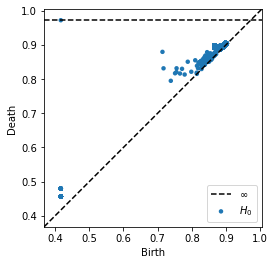

In [9]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips['dgms'][0])

## Pruned LT Homology

In [10]:
# load the LT model.
model_lt = torch.load(model_loc1)

/home/schraterlab/anaconda3/lib/python3.8/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [11]:
# test this model's accuracy.
print('Accuracy: {}'.format(test(model_lt, test_loader, criterion)))

Accuracy: 98.35


In [14]:
NNGLT = nn_graph.NNGraph()
NNGLT.parameter_graph(model_lt, model_class.param_info, input_size, ignore_zeros=True, verbose=True)

Layer: Conv1
Layer: Conv2
Layer: MaxPool1
Layer: Linear1
Layer: Linear2
Layer: Linear3


In [15]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
sps = nx.to_scipy_sparse_matrix(NNGLT.G)
mrs = sparse_min_row(sps)
sps.setdiag(mrs)
%time rips_lt = ripser(sps, distance_matrix=True, maxdim=1)
rips_lt

/home/schraterlab/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 2min 2s, sys: 848 ms, total: 2min 2s
Wall time: 2min 2s


{'dgms': [array([[0.35726291, 0.38347414],
         [0.35726291, 0.38347414],
         [0.35726291, 0.38347414],
         ...,
         [0.93129712, 0.93377346],
         [0.93129712, 0.93460172],
         [0.35726291,        inf]]),
  array([[1.        ,        inf],
         [1.        ,        inf],
         [1.        ,        inf],
         ...,
         [0.40771228,        inf],
         [0.40771228,        inf],
         [0.40771228,        inf]])],
 'cocycles': [[], []],
 'num_edges': 14328369,
 'dperm2all': <114202x114202 sparse matrix of type '<class 'numpy.float64'>'
 	with 28770940 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([     0,      1,      2, ..., 114199, 114200, 114201]),
 'r_cover': 0.0}

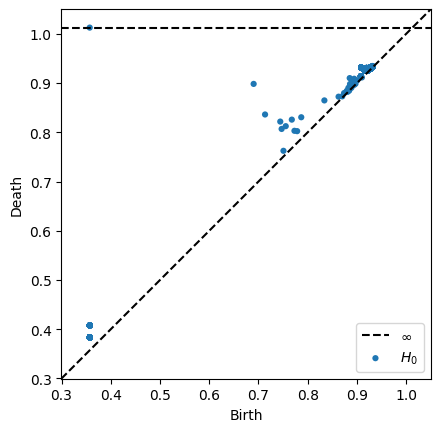

In [16]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips_lt['dgms'][0])